# Programming Assignment: Numerical Optimization for Logistic Regression.

### Name: Wyatt Blair


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes.txt')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.07720387 -0.08673922 -0.03226863  0.13048335  0.00119911 -0.05280882
   0.05736515  0.08130271]]
test std = 
[[0.90040256 1.01961388 0.91461755 0.89633591 1.02591541 0.83302593
  0.91128826 1.15434238]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [5]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [6]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
# print('Initial objective function value = ' + str(objval0))

# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [8]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        # print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [9]:
lam = 1E-6
stepsize = 1.0
w_gd, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [10]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [11]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        # print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [12]:
lam = 1E-6
stepsize = 0.1
w_sgd, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

# 4. Compare GD with SGD

Plot objective function values against epochs.

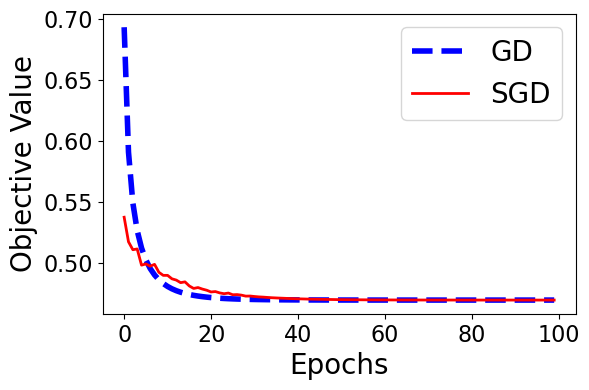

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', lw=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', lw=2)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Objective Value', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [14]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [15]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.5


In [16]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.5


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [17]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications

    # reshape y so it can multiply all of x at once
    b, d = xi.shape

    # Objective function
    reg = lam / 2 * numpy.sum(w * w) # scalar

    yx = numpy.multiply(yi, xi) # b-by-d matrix
    yxw = numpy.dot(yx, w) # b-by-1 matrix
    power = numpy.exp(-yxw) # b-by-1 matrix
    terms = numpy.log(1 + power) # b-by-1 matrix
    obj = 1/b * numpy.sum(terms) + reg # scalar

    # Gradient function
    numerator = -yx
    denominator = 1 + numpy.exp(yxw)
    division = numerator / denominator

    g_reg = lam * w
    g_delta = 1/b * division.sum(0)

    g = g_delta.T + g_reg     # d-by-1 vector

    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


##### Defining some helper functions

In [18]:
class mb_sgd:

    def __init__(self, x, y, lam, b, stepsize, max_epoch=100, w=None, random=True, verbose=True):

        # set constants
        self.n, self.d = x.shape

        # unpack parameters and data
        self.x = x
        self.y = y
        self.lam = lam
        self.b = b
        self.stepsize = stepsize
        self.max_epoch = max_epoch
        self.w = w

        if self.w is None:
                    self.w = numpy.zeros((self.d, 1))

        # total number of batches per epoch
        self.num_iters_per_epoch = int(numpy.ceil(self.n/self.b))

        # these will be set as training occurs
        self.x_rand = None
        self.y_rand = None
        self.objvals = None

        # optional parameters from user
        self.random = random
        self.verbose = verbose

    def shuffle_data(self):
        
        # shuffle all the indicies of the data
        rand_indices = numpy.random.permutation(self.n)
        self.x_rand = self.x[rand_indices, :]
        self.y_rand = self.y[rand_indices, :]

    def make_batch(self, i, random=True):

        # determine the start and end of each batch slice
        batch_start_ind = i * self.b
        batch_end_ind = min((i + 1) * self.b, self.n)

        # select either from randomized array or original array
        if random:
            xi = self.x_rand[batch_start_ind:batch_end_ind, :] # b-by-d matrix
            yi = self.y_rand[batch_start_ind:batch_end_ind, :] # b-by-1 vector
        else:
            xi = self.x[batch_start_ind:batch_end_ind, :] # b-by-d matrix
            yi = self.y[batch_start_ind:batch_end_ind, :] # b-by-1 vector

        return xi, yi

    def epoch_loop(self, random=True):

        # randomly shuffle the samples
        if random:
            self.shuffle_data()

        objval = 0 # accumulate the objective values
        for i in range(self.num_iters_per_epoch):

            xi, yi = self.make_batch(i=i, random=random)
            obj, g = mb_stochastic_objective_gradient(self.w, xi, yi, lam=self.lam)

            objval += obj
            self.w -= stepsize * g
        
        self.stepsize *= 0.9 # decrease step size
        objval /= self.b

        return objval

    # ===============================================================================================

    def train(self):

        # optimize the weights using the given parameters
        self.objvals = numpy.zeros(self.max_epoch) # store the objective values
        for t in range(self.max_epoch):

            objval = self.epoch_loop(random=self.random)
            self.objvals[t] = objval

            if self.verbose: print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
        
        return self.w, self.objvals
    
    def __call__(self):
         
        return self.train()
    

## 6.3. Run MB-SGD

In [19]:
# Re-organizing parameters so everything is easier to tune, no values were altered 
# which I was not allowed to alter

mbsgd8_model_kwargs = {
    'x': x_train,       # don't change
    'y': y_train,       # don't change
    'lam': 1E-6,        # don't change
    'b': 8,             # don't change
    'stepsize': 0.001,   # must tune
    'verbose': False,
}

mbsgd64_model_kwargs = {
    'x': x_train,       # don't change
    'y': y_train,       # don't change
    'lam': 1E-6,        # don't change
    'b': 64,            # don't change
    'stepsize': 1,      # must tune
    'verbose': False,
}

mbsgd8_model = mb_sgd(**mbsgd8_model_kwargs)
mbsgd64_model = mb_sgd(**mbsgd64_model_kwargs)

In [20]:
# MB-SGD with batch size b=8
w_mbsgd8, objvals_mbsgd8 = mbsgd8_model()

In [21]:
# MB-SGD with batch size b=64
w_mbsgd64, objvals_mbsgd64 = mbsgd64_model()

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

In [22]:
import seaborn as sns

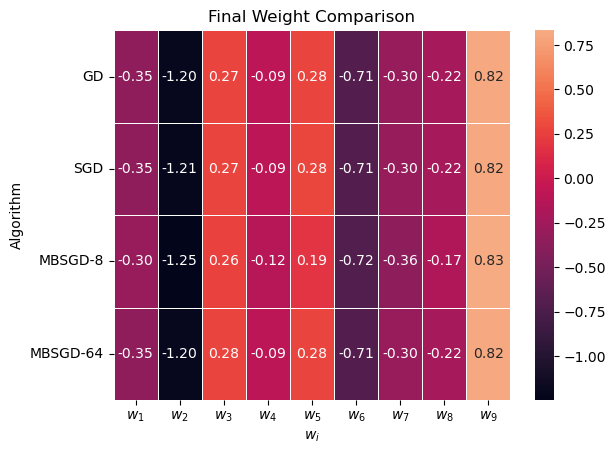

In [23]:
# Going to create a heatmap comparing the output weights from each algorithm
# That way I can easily identify whether or not my model is producing
# the same output as the GD and SGD algorithm, like we'd expect

weights = {'GD': w_gd, 'SGD': w_sgd, 'MBSGD-8': w_mbsgd8, 'MBSGD-64': w_mbsgd64}

ws_data = numpy.stack(
    list(weights.values())
).squeeze()

sns.heatmap(
    ws_data, 
    annot=True, 
    fmt=".2f", 
    linewidths=.5, 
    center=0,
    xticklabels=[f"$w_{i+1}$" for i in range(ws_data.shape[1])],
    yticklabels=weights.keys(),
    cmap='rocket',
    square=False,
)

# Setting the position of the ticks in the center of each cell
plt.xticks(rotation=0, ha='center')  # Center the column labels and avoid rotation
plt.yticks(rotation=0, va='center')  # Center the row labels

plt.title('Final Weight Comparison')
plt.xlabel('$w_i$')
plt.ylabel('Algorithm')

plt.show()

### The above heatmap should have identical rows if the algorithms came to the same solution

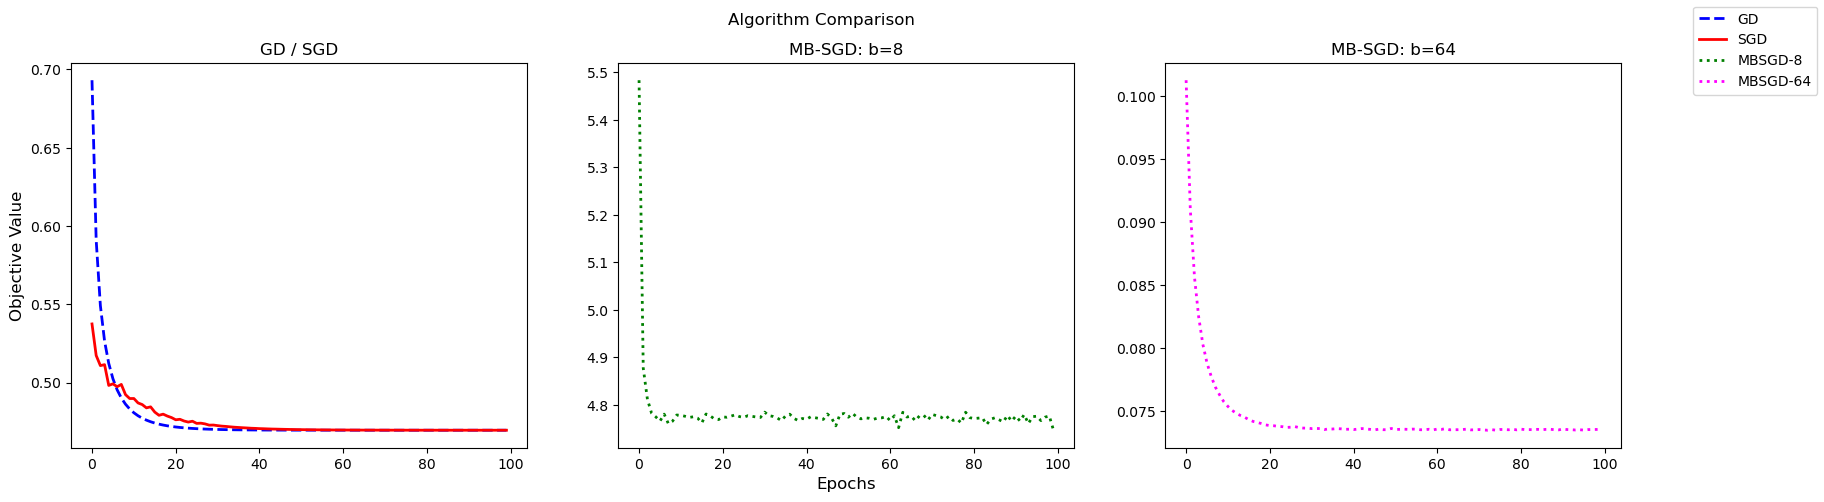

In [24]:
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

fig, (gd_sgd_ax, mbsgd8_ax, mbsgd64_ax) = plt.subplots(1, 3, figsize=(20, 5))

gd_sgd_ax.plot(epochs_gd, objvals_gd, '--b', label='GD', lw=2)
gd_sgd_ax.plot(epochs_sgd, objvals_sgd, '-r', label='SGD', lw=2)
mbsgd8_ax.plot(epochs_mbsgd8, objvals_mbsgd8, label='MBSGD-8', color='green', linestyle=':', lw=2)
mbsgd64_ax.plot(epochs_mbsgd64, objvals_mbsgd64, label='MBSGD-64', color='magenta', linestyle=':', lw=2)

fig.legend()

gd_sgd_ax.set_title('GD / SGD')
mbsgd8_ax.set_title('MB-SGD: b=8')
mbsgd64_ax.set_title('MB-SGD: b=64')
mbsgd8_ax.set_xlabel('Epochs', fontsize=12)
gd_sgd_ax.set_ylabel('Objective Value', fontsize=12)

fig.suptitle('Algorithm Comparison')
plt.show()

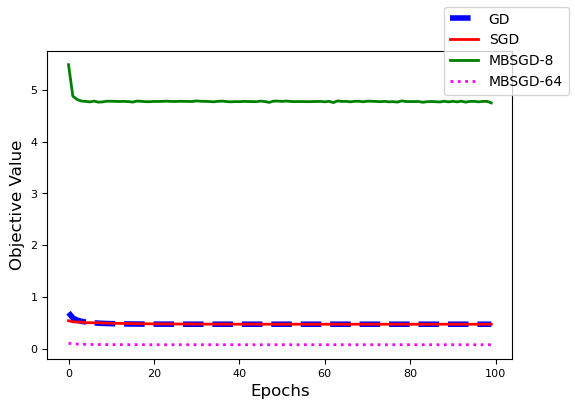

In [25]:
# plot the 4 curves:
fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))
epochs_mbsgd8 = range(len(objvals_mbsgd8))
epochs_mbsgd64 = range(len(objvals_mbsgd64))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', lw=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', lw=2)
line2, = plt.plot(epochs_mbsgd8, objvals_mbsgd8, color='green', lw=2)
line3, = plt.plot(epochs_mbsgd64, objvals_mbsgd64, color='magenta', linestyle=':', lw=2)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Objective Value', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
fig.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MBSGD-8', 'MBSGD-64'], fontsize=10)
plt.show()
fig.savefig('compare_gd_sgd_mbsgd8_mbsgd64.pdf', format='pdf', dpi=1300)